# Assignment 1

**Handin**: *Friday*, March 11, 2022, 23:59<br>
The most important helper functions are copied from their original exercise sets but there are some you will have to copy by yourself. etc). Run the code so that the code produces outputs and plots. Once you're satisfied go ahead and upload it.

In [3]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

### Week 1

In [4]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q1: Print these out for a network of size `[2, 3, 1]`, and explain their structure and contents
        # Questions answered below!
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q2: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        # Questions answered below!
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    
    # --------------------------------------------------------------------------- #
    # Don't worry too much about the code below. We will look into that next week #
    # --------------------------------------------------------------------------- #
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  ``epochs`` represents the number of training iterations
        over the training data.  ``eta`` is the learning rate.
        If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

In [5]:
### MY ANSWER ###
n = Network([2,3,1])
print("Biases: ", n.biases)
print("Weights: ", n.weights)

# Q1
# Weights determine how much value one neuron holds compared to others. 
# Biases are scalars added to the result of a neuron to offset its value.
#
# In this case, there are two arrays in Biases, the first is the biases for each neuron in the second layer. 
# The second array just holds the bias for the one neuron in the 3rd layer. The input layer does not have biases.
# Weights is structured so that there is a value for each connection instead of for each neuron. 
# So the first array holds 3 arrays with two values each. The 6 total values represent the 6 connections between 
# the first layer of 2 nodes and the second layer of 3 nodes. The second array has 3 values for the 3 connections 
# between the 3 nodes in the second layer and the 1 final node.

# Q2
# the 'a' the is activation value for each neuron. 
# This loop iterates for every neuron in the network except the first layer.
# It will be the shape of the bias array for each layer.


Biases:  [array([[2.2587103 ],
       [1.21451681],
       [0.05496311]]), array([[-0.52645043]])]
Weights:  [array([[ 0.59693976, -1.19448525],
       [-1.57298861,  1.57306076],
       [-0.78255781, -0.05446073]]), array([[-1.74176482, -0.8996329 , -1.61700262]])]


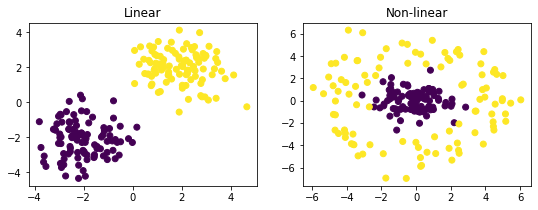

In [6]:
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-2, -2], 1, size=(int(N/2), 2)),
        np.random.normal([2, 2], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

def generate_X_nonlinear(N=200, R=5):
    X_inner = np.random.normal([0, 0], 1, size=(int(N/2), 2))

    X_outer = np.array([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + np.random.randn(int(N/2), 2)

    X = np.vstack([X_inner, X_outer])
    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

plt.figure(figsize=(9, 3))

X, y = generate_X_linear()
plt.subplot(1, 2, 1)
plt.title("Linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

X, y = generate_X_nonlinear()
plt.subplot(1, 2, 2)
plt.title("Non-linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

The data needs to be formatted a little different when we give it to Nielsen's code. Basically, it asks for (x, y) tuple pairs, so in each tuple you have a datapoint and it's label. Furthermore, both x and y must be vertical vectors **(if you don't undertstand why, you didn't complete Ex. 1.2.1 properly)**.

The function below takes `X` and `y` and returns the data in this format:

In [7]:
def prepare_data(X, y):
    """Format the dataset X and y so it fits with Nielsen's code."""
    return [
        (X[i].reshape(-1, 1), y[i].reshape(-1, 1))  # our tuple (x, y)
        for i in range(len(y))
    ]

> **Ex. 1.2.2**: Create a neural network called `net` with `sizes=[2, 1]`. This is actually just the basic Perceptron with two inputs and a single output (or a logistic regression with two variables). Generate 1e5 training datapoints and 1e4 testing datapoints using the `generate_X_linear` function. Once you've done that run the code below to train the network and to get predictions for the test data.  

In [8]:
### MY SOLUTION ###

net = Network([2,1])
X_train, y_train = generate_X_linear(100000)
X_test, y_test = generate_X_linear(10000)

training_data = prepare_data(X_train, y_train)
test_data = prepare_data(X_test, y_test)

In [9]:
net.SGD(
    training_data,
    epochs=10,
    mini_batch_size=10,
    eta=1,
    test_data=test_data
)

# Get predictions
y_pred = []
for x in X_test:
    y_pred.append(net.feedforward(x.reshape(-1, 1))[0][0])

Epoch 0: 9983 / 10000
Epoch 1: 9983 / 10000
Epoch 2: 9984 / 10000
Epoch 3: 9985 / 10000
Epoch 4: 9985 / 10000
Epoch 5: 9983 / 10000
Epoch 6: 9983 / 10000
Epoch 7: 9984 / 10000
Epoch 8: 9985 / 10000
Epoch 9: 9983 / 10000


>Have a look at the predictions, e.g., print some of those values.  What do they look like? Are they just 0s and 1s? **Explain.**

In [8]:
### MY SOLUTION ###
print(y_pred)

# They are not just 0s and 1s. Because they are a probability of the classification of each point. 

[1.4492293891938924e-08, 5.9450578879361235e-08, 3.6725280148274177e-13, 1.3696504530997813e-06, 3.1170320464129336e-10, 8.577919947897748e-08, 1.1896826895416388e-06, 1.9384189366454396e-09, 9.58118572357325e-10, 0.00015443054191559223, 0.0027052557667771975, 7.731172371241319e-08, 2.493010908969258e-10, 8.382385506990757e-07, 2.7854795275705366e-09, 0.009976719285500212, 2.2920779330913008e-06, 1.8487929232485671e-09, 3.3991159691796993e-06, 5.8349628698100326e-08, 0.0048534909366662144, 2.309954206091925e-05, 1.0792617747170449e-10, 1.0908379398200717e-07, 0.9227549644395302, 3.128319899970259e-07, 1.8912580582720724e-10, 9.141962655309948e-06, 7.946188045664449e-07, 1.960336664600226e-07, 0.22151739551550553, 9.096071008597688e-06, 3.391753417380571e-09, 0.00015252243652019056, 6.542544613834187e-07, 3.89930190912645e-06, 1.245388565865297e-05, 1.7804912274204909e-06, 3.582335864497758e-12, 8.20532287495645e-08, 1.7493935504229992e-06, 7.169607631607935e-07, 0.00013553488237370953,

>Once you've answered the question above, go ahead and run the code below to plot, side by side, the predictions versus the true labels.  **Comment on the differences.**

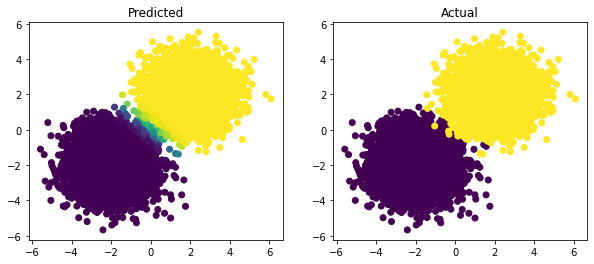

In [10]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_pred))
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_test.reshape(-1)))

In [10]:
### MY SOLUTION ###

# We can see some blue-green points around the center. 
# This is where the network is less certain about the classification of points.
# Some points that are completely out of their zone are misclassified by the network

> **Ex. 1.2.3**: Now we want to do the same thing as in Ex. 1.2.2, but with the data generated with the `generate_X_nonlinear` function. Comment on the result!
>
>*Hint: Think back to the lecture slides to figure out the size of the network you need in order to fit this kind of data.

In [11]:
### MY SOLUTION ###

net = Network([2,3,1])
X_train, y_train = generate_X_nonlinear(100000)
X_test, y_test = generate_X_nonlinear(10000)

training_data = prepare_data(X_train, y_train)
test_data = prepare_data(X_test, y_test)

net.SGD(
    training_data,
    epochs=10,
    mini_batch_size=10,
    eta=1,
    test_data=test_data
)

# Get predictions
y_pred = []
for x in X_test:
    y_pred.append(net.feedforward(x.reshape(-1, 1))[0][0])
    

Epoch 0: 9802 / 10000
Epoch 1: 9806 / 10000
Epoch 2: 9818 / 10000
Epoch 3: 9784 / 10000
Epoch 4: 9797 / 10000
Epoch 5: 9836 / 10000
Epoch 6: 9810 / 10000
Epoch 7: 9826 / 10000
Epoch 8: 9789 / 10000
Epoch 9: 9832 / 10000


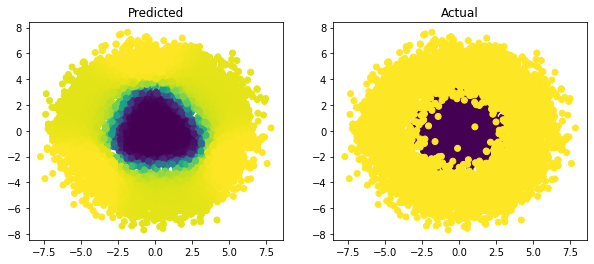

In [12]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_pred))
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_test.reshape(-1)))

In [11]:
### MY SOLUTION ###

# Here the uncertainty forms a circle around the inner points. 
# Some of the yellow dots in the middle of the purple ones were misclassified.

### Week 2

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?


In [14]:
### MY SOLUTION ###

# 1. sigmoid((4*0.5) + (2*1) + 1 ) = sigmoid(5) = 0.9933071
# 2. sigmoid((4*2) + (2*10) -1 ) = sigmoid(27) = 1
# 3. sigmoid((4*-5) + (2*0.3) +2 ) = sigmoid(-17.4) = 0
# 4. sigmoid((0.9933071*12) + (1*-8) + (0*0.2) - 3) = sigmoid(0.9196852) = 0.71497796
        
# Cost =  (0.71497796 - 1)^2 = 0.0812375
  

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*
> *Hint: Some of the gradients will become VERY small (remember the vanishing gradient problem?). If they get smaller than 1e-4 you can just set them to zero.*

![img.jpg](https://raw.githubusercontent.com/jackbodine/NeuralNetworksAssignment1/main/img.jpg)


In [2]:
# 0.0277
# 0.0555     0.0555     2.7684    0.2307

# 0.2354
# 1.1770     0.1177     -1.8456   0.2307    0.2307    -0.5702

# -1.249
# 0.0749     0.2498     0.0461    0.2307

### Week 3

In [13]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

> **Ex. 3.1.2** Solve exercises 1.2.2 and 1.2.3 from week 1, but solve them using Keras.
> Comment on differences in speed (and outcome if you observe any).

In [14]:
### MY SOLUTION ###

X_train_2_linear, y_train_2_linear = generate_X_linear(100000)
X_test_2_linear, y_test_2_linear = generate_X_linear(10000)

model = Sequential()
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

model.fit(X_train_2_linear, y_train_2_linear, epochs=10, batch_size=128)

# Seems to be quicker than the previous method.
# Accuracy is usualy about 0.9975

2022-03-11 12:49:14.158315: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 12:49:14.159193: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 2s 17us/sample - loss: 0.0981 - accuracy: 0.9136
Epoch 2/10
100000/100000 [==============================] - 1s 11us/sample - loss: 0.0453 - accuracy: 0.9951
Epoch 3/10
100000/100000 [==============================] - 1s 11us/sample - loss: 0.0305 - accuracy: 0.9943
Epoch 4/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.0230 - accuracy: 0.9942
Epoch 5/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.0186 - accuracy: 0.9945
Epoch 6/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.0156 - accuracy: 0.9948
Epoch 7/10
100000/100000 [==============================] - 1s 13us/sample - loss: 0.0135 - accuracy: 0.9951
Epoch 8/10
100000/100000 [==============================] - 1s 13us/sample - loss: 0.0119 - accuracy: 0.9953
Epoch 9/10
100000/100000 [==============================] - 1s 13us/sample - loss: 0.0107 - accuracy: 0.

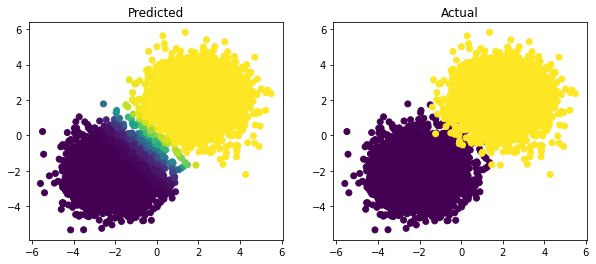

In [15]:
# Plot
predictions = model.predict(X_test_2_linear)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.scatter(X_test_2_linear[:, 0], X_test_2_linear[:, 1], c=list(predictions))
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.scatter(X_test_2_linear[:, 0], X_test_2_linear[:, 1], c=list(y_test_2_linear.reshape(-1)))

In [16]:
### MY SOLUTION ###

X_train_2_nonlinear, y_train_2_nonlinear = generate_X_nonlinear(100000)
X_test_2_nonlinear, y_test_2_nonlinear = generate_X_nonlinear(10000)

model = Sequential()
model.add(Dense(2, activation = 'relu'))
model.add(Dense(3, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

model.fit(X_train_2_nonlinear, y_train_2_nonlinear, epochs=10, batch_size=128)

# Also a bit quicker than using the previous method.
# Accuracy is usualy around 0.65-0.67. 

Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 2s 16us/sample - loss: 0.2257 - accuracy: 0.5479
Epoch 2/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.2195 - accuracy: 0.5978
Epoch 3/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.2160 - accuracy: 0.6194
Epoch 4/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.2133 - accuracy: 0.6321
Epoch 5/10
100000/100000 [==============================] - 1s 12us/sample - loss: 0.2111 - accuracy: 0.6411
Epoch 6/10
100000/100000 [==============================] - 1s 13us/sample - loss: 0.2092 - accuracy: 0.6485
Epoch 7/10
100000/100000 [==============================] - 1s 14us/sample - loss: 0.2076 - accuracy: 0.6540
Epoch 8/10
100000/100000 [==============================] - 1s 14us/sample - loss: 0.2062 - accuracy: 0.6588
Epoch 9/10
100000/100000 [==============================] - 1s 14us/sample - loss: 0.2052 - accuracy: 0.

> **Ex. 3.2.1** To understand overfitting, we will intentionally overfit some data! Let's fit a neural network to the following data.  

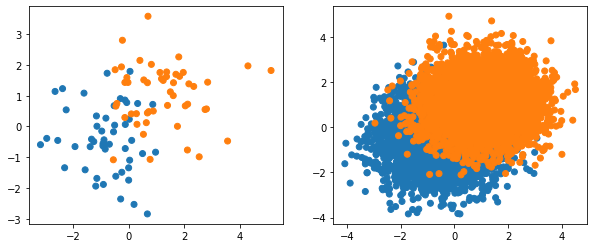

In [17]:
#code given in week1 exercise 1.2.2, slightly modified to have some crossover points
np.random.seed(2)
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-0.5, -0.5], 1, size=(int(N/2), 2)),
        np.random.normal([1, 1], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

ntr=100
nts=1e4
x_train, y_train = generate_X_linear(N=ntr)
x_test, y_test = generate_X_linear(N=nts)

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].scatter(x_train[:,0],x_train[:,1],color=['C'+str(i) for i in y_train.ravel()])
ax[1].scatter(x_test[:,0],x_test[:,1],color=['C'+str(i) for i in y_test.ravel()])

> The theoretical optimal decision boundary here is a straight line, and since the clusters are overlapping there should be some error when fitting the model to the data. Try to reduce the error to 0 anyway (accuracy = 1) by adding layers of ``overfitter.add(Dense(200, activation = 'relu'))`` to the code below

In [60]:
overfitter = Sequential()
overfitter.add(Dense(200, input_dim=2, activation = 'relu'))
overfitter.add(Dense(200, activation = 'relu'))
overfitter.add(Dense(200, activation = 'relu'))
overfitter.add(Dense(1, activation='sigmoid'))

overfitter.compile(optimizer='adam',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

# fit the model to the training data
history = overfitter.fit(x_train, y_train, epochs=300, batch_size=128)

Train on 100 samples
Epoch 1/300
100/100 [==============================] - 1s 6ms/sample - loss: 0.6962 - accuracy: 0.4300
Epoch 2/300
100/100 [==============================] - 0s 52us/sample - loss: 0.6369 - accuracy: 0.8800
Epoch 3/300
100/100 [==============================] - 0s 71us/sample - loss: 0.5870 - accuracy: 0.8900
Epoch 4/300
100/100 [==============================] - 0s 57us/sample - loss: 0.5426 - accuracy: 0.8800
Epoch 5/300
100/100 [==============================] - 0s 57us/sample - loss: 0.5023 - accuracy: 0.8800
Epoch 6/300
100/100 [==============================] - 0s 98us/sample - loss: 0.4648 - accuracy: 0.8800
Epoch 7/300
100/100 [==============================] - 0s 51us/sample - loss: 0.4299 - accuracy: 0.8800
Epoch 8/300
100/100 [==============================] - 0s 52us/sample - loss: 0.3975 - accuracy: 0.8800
Epoch 9/300
100/100 [==============================] - 0s 51us/sample - loss: 0.3685 - accuracy: 0.8800
Epoch 10/300
100/100 [======================

Epoch 79/300
100/100 [==============================] - 0s 56us/sample - loss: 0.2239 - accuracy: 0.8900
Epoch 80/300
100/100 [==============================] - 0s 60us/sample - loss: 0.2233 - accuracy: 0.8900
Epoch 81/300
100/100 [==============================] - 0s 60us/sample - loss: 0.2227 - accuracy: 0.8900
Epoch 82/300
100/100 [==============================] - 0s 66us/sample - loss: 0.2221 - accuracy: 0.8900
Epoch 83/300
100/100 [==============================] - 0s 62us/sample - loss: 0.2214 - accuracy: 0.8900
Epoch 84/300
100/100 [==============================] - 0s 64us/sample - loss: 0.2208 - accuracy: 0.8900
Epoch 85/300
100/100 [==============================] - 0s 63us/sample - loss: 0.2202 - accuracy: 0.8900
Epoch 86/300
100/100 [==============================] - 0s 63us/sample - loss: 0.2195 - accuracy: 0.8900
Epoch 87/300
100/100 [==============================] - 0s 59us/sample - loss: 0.2189 - accuracy: 0.8900
Epoch 88/300
100/100 [==============================] -

Epoch 157/300
100/100 [==============================] - 0s 82us/sample - loss: 0.1268 - accuracy: 0.9700
Epoch 158/300
100/100 [==============================] - 0s 60us/sample - loss: 0.1248 - accuracy: 0.9600
Epoch 159/300
100/100 [==============================] - 0s 59us/sample - loss: 0.1227 - accuracy: 0.9700
Epoch 160/300
100/100 [==============================] - 0s 57us/sample - loss: 0.1211 - accuracy: 0.9700
Epoch 161/300
100/100 [==============================] - 0s 59us/sample - loss: 0.1194 - accuracy: 0.9600
Epoch 162/300
100/100 [==============================] - 0s 62us/sample - loss: 0.1175 - accuracy: 0.9700
Epoch 163/300
100/100 [==============================] - 0s 55us/sample - loss: 0.1157 - accuracy: 0.9700
Epoch 164/300
100/100 [==============================] - 0s 62us/sample - loss: 0.1142 - accuracy: 0.9700
Epoch 165/300
100/100 [==============================] - 0s 64us/sample - loss: 0.1125 - accuracy: 0.9700
Epoch 166/300
100/100 [=======================

Epoch 235/300
100/100 [==============================] - 0s 55us/sample - loss: 0.0260 - accuracy: 1.0000
Epoch 236/300
100/100 [==============================] - 0s 57us/sample - loss: 0.0255 - accuracy: 1.0000
Epoch 237/300
100/100 [==============================] - 0s 54us/sample - loss: 0.0249 - accuracy: 1.0000
Epoch 238/300
100/100 [==============================] - 0s 59us/sample - loss: 0.0244 - accuracy: 1.0000
Epoch 239/300
100/100 [==============================] - 0s 58us/sample - loss: 0.0239 - accuracy: 1.0000
Epoch 240/300
100/100 [==============================] - 0s 60us/sample - loss: 0.0234 - accuracy: 1.0000
Epoch 241/300
100/100 [==============================] - 0s 58us/sample - loss: 0.0230 - accuracy: 1.0000
Epoch 242/300
100/100 [==============================] - 0s 55us/sample - loss: 0.0225 - accuracy: 1.0000
Epoch 243/300
100/100 [==============================] - 0s 57us/sample - loss: 0.0220 - accuracy: 1.0000
Epoch 244/300
100/100 [=======================

> When you get acc=1, plot the test data and colour it using the predictions of your neural network

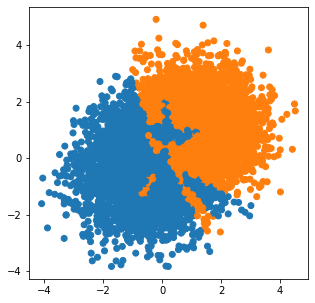

In [61]:
pred = overfitter.predict_classes(x_test).ravel()
fig,ax = plt.subplots(1,1, figsize=[5,5])
ax.scatter(x_test[:,0],x_test[:,1],c=['C'+str(i) for i in pred])

> Now add some L2 regularization ( ``... activation = 'relu', kernel_regularizer=l2(0.05)) `` ) into that same overfitting network in order to get a linear decision boundary. Plot the test data colour it using your predictions as before. Comment on the differences.

Train on 100 samples
Epoch 1/300
100/100 [==============================] - 1s 9ms/sample - loss: 4.6810 - accuracy: 0.6500
Epoch 2/300
100/100 [==============================] - 0s 50us/sample - loss: 4.5520 - accuracy: 0.8600
Epoch 3/300
100/100 [==============================] - 0s 54us/sample - loss: 4.4307 - accuracy: 0.8800
Epoch 4/300
100/100 [==============================] - 0s 59us/sample - loss: 4.3156 - accuracy: 0.8800
Epoch 5/300
100/100 [==============================] - 0s 56us/sample - loss: 4.2055 - accuracy: 0.8700
Epoch 6/300
100/100 [==============================] - 0s 64us/sample - loss: 4.0992 - accuracy: 0.8600
Epoch 7/300
100/100 [==============================] - 0s 56us/sample - loss: 3.9960 - accuracy: 0.8600
Epoch 8/300
100/100 [==============================] - 0s 56us/sample - loss: 3.8955 - accuracy: 0.8600
Epoch 9/300
100/100 [==============================] - 0s 58us/sample - loss: 3.7978 - accuracy: 0.8600
Epoch 10/300
100/100 [======================

Epoch 79/300
100/100 [==============================] - 0s 53us/sample - loss: 0.7436 - accuracy: 0.8900
Epoch 80/300
100/100 [==============================] - 0s 55us/sample - loss: 0.7289 - accuracy: 0.8900
Epoch 81/300
100/100 [==============================] - 0s 54us/sample - loss: 0.7146 - accuracy: 0.8900
Epoch 82/300
100/100 [==============================] - 0s 54us/sample - loss: 0.7008 - accuracy: 0.8900
Epoch 83/300
100/100 [==============================] - 0s 55us/sample - loss: 0.6873 - accuracy: 0.8900
Epoch 84/300
100/100 [==============================] - 0s 58us/sample - loss: 0.6743 - accuracy: 0.8900
Epoch 85/300
100/100 [==============================] - 0s 70us/sample - loss: 0.6616 - accuracy: 0.8900
Epoch 86/300
100/100 [==============================] - 0s 59us/sample - loss: 0.6493 - accuracy: 0.8900
Epoch 87/300
100/100 [==============================] - 0s 58us/sample - loss: 0.6374 - accuracy: 0.8900
Epoch 88/300
100/100 [==============================] -

Epoch 157/300
100/100 [==============================] - 0s 55us/sample - loss: 0.3024 - accuracy: 0.8900
Epoch 158/300
100/100 [==============================] - 0s 61us/sample - loss: 0.3012 - accuracy: 0.8900
Epoch 159/300
100/100 [==============================] - 0s 57us/sample - loss: 0.3000 - accuracy: 0.8900
Epoch 160/300
100/100 [==============================] - 0s 54us/sample - loss: 0.2988 - accuracy: 0.8900
Epoch 161/300
100/100 [==============================] - 0s 55us/sample - loss: 0.2977 - accuracy: 0.8900
Epoch 162/300
100/100 [==============================] - 0s 58us/sample - loss: 0.2966 - accuracy: 0.8900
Epoch 163/300
100/100 [==============================] - 0s 57us/sample - loss: 0.2956 - accuracy: 0.8900
Epoch 164/300
100/100 [==============================] - 0s 78us/sample - loss: 0.2946 - accuracy: 0.8900
Epoch 165/300
100/100 [==============================] - 0s 59us/sample - loss: 0.2936 - accuracy: 0.8900
Epoch 166/300
100/100 [=======================

Epoch 235/300
100/100 [==============================] - 0s 64us/sample - loss: 0.2665 - accuracy: 0.8900
Epoch 236/300
100/100 [==============================] - 0s 60us/sample - loss: 0.2664 - accuracy: 0.8900
Epoch 237/300
100/100 [==============================] - 0s 57us/sample - loss: 0.2663 - accuracy: 0.8900
Epoch 238/300
100/100 [==============================] - 0s 60us/sample - loss: 0.2661 - accuracy: 0.8900
Epoch 239/300
100/100 [==============================] - 0s 61us/sample - loss: 0.2660 - accuracy: 0.8900
Epoch 240/300
100/100 [==============================] - 0s 64us/sample - loss: 0.2659 - accuracy: 0.8900
Epoch 241/300
100/100 [==============================] - 0s 59us/sample - loss: 0.2658 - accuracy: 0.8900
Epoch 242/300
100/100 [==============================] - 0s 56us/sample - loss: 0.2657 - accuracy: 0.8900
Epoch 243/300
100/100 [==============================] - 0s 56us/sample - loss: 0.2655 - accuracy: 0.8900
Epoch 244/300
100/100 [=======================

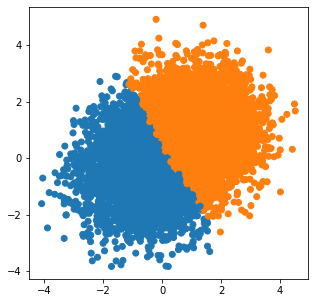

In [62]:
overfitter = Sequential()
overfitter.add(Dense(200, input_dim=2, activation = 'relu'))
overfitter.add(Dense(200, activation = 'relu', kernel_regularizer='l2')) # With regularizer
overfitter.add(Dense(200, activation = 'relu', kernel_regularizer='l2')) # With regularizer
overfitter.add(Dense(1, activation='sigmoid'))

overfitter.compile(optimizer='adam',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

# fit the model to the training data
history = overfitter.fit(x_train, y_train, epochs=300, batch_size=128)

pred = overfitter.predict_classes(x_test).ravel()
fig,ax = plt.subplots(1,1, figsize=[5,5])
ax.scatter(x_test[:,0],x_test[:,1],c=['C'+str(i) for i in pred])

In [ ]:
### MY SOLUTION ###

# The first network overfits the data without any regularization. 
# Because it is attempting to overfit overlapping data it results in the weird clumps and shapes that we see.

# The second network uses l2 regularization. We see much closer to a straight line decision boundary.
# The test accuracy is worse for the second network but it isn't overfitted so it may better predict real testing data

### Week 4

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

In [63]:
### MY SOLUTION ###

# (28-5+2*2)/1 + 1 = 28

# The resulting activation map is 28x28x1

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?

In [ ]:
### MY SOLUTION ###

# (28-5+2*2)/2 + 1 = 14.5

# We don't get an integer value from the formula, so the filter doesn't fit the dimensions of the image.
# There would be some overlap when it 'slid' to the end.
# We can change the filter size to an even number to fix this.

> **Ex. 4.1.5**: Implement Nielsen's [convolutional neural networks](http://neuralnetworksanddeeplearning.com/chap6.html#exercise_683491)
(for this assignment only include the last network from the textbook, the one with 2 convolutional layers and dropout), and score an accuracy higher than 98%. The implementations don't have to be
fully identical, but his solutions are pretty great, so getting close is a cheap way to score a high accuracy.


In [64]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist

In [65]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data so it has a channel dimension
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
    
# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [66]:
### MY SOLUTION ###

model = Sequential([
    Conv2D(20, kernel_size=(5, 5), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(40, kernel_size=(5, 5), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(1000, activation="relu"),
    Dropout(0.5),
    
    Dense(1000, activation="relu"),
    Dropout(0.5),

    Dense(10, activation="softmax")
])

model.compile('adam', 'mean_squared_error', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=200)
score = model.evaluate(x_test, y_test, batch_size=200)

# Note: Takes a while to run but usually reaches 98% accuracy by the third epoch.

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0116 - accuracy: 0.9182
Epoch 2/5
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.0033 - accuracy: 0.9790
Epoch 3/5
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.0025 - accuracy: 0.9844
Epoch 4/5
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.0020 - accuracy: 0.9871
Epoch 5/5
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.0016 - accuracy: 0.9895
10000/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================